<a href="https://colab.research.google.com/github/paulcodrea/reddit_humor/blob/main/Humour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Get reddit /r/dadjokes data
import requests
import pandas as pd

url = "https://www.reddit.com/r/dadjokes.json"
resp = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'limit': '100'})
data = resp.json()
data_list = []
data_list.append(data)
# repeat process 9 more times with updated 'after' param
for i in range(9):
  after_param = data['data']['after'] 
  data = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'after': after_param, 'limit': '100'})
  data_2 = data.json()
  data_list.append(data_2)
  data = data_2

In [7]:
# create a list of all jokes in json format
data = []
for collection in data_list:
  collection_list = collection['data']['children']
  for joke_index in range(len(collection_list)):
    data.append(collection_list[joke_index]['data'])

### Save only important columns in dataframe

In [13]:
df = pd.DataFrame(data)
clean_df = pd.DataFrame()

clean_df['title'] = df['title']
clean_df['selftext'] = df['selftext']
clean_df['ups'] = df['ups']
clean_df['downs'] = df['downs']
clean_df['upvote_ratio'] = df['upvote_ratio']
clean_df['total_awards_received'] = df['total_awards_received']

In [24]:
# save the jokes in a csv file for later use
clean_df.to_csv(f'1_reddit_dadjokes({len(clean_df)}).csv')

### Plot the stats of the reddit jokes

Number of jokes with upvotes different from zero:  893
Number of jokes with downvotes different from zero:  0
Number of jokes with no engagement:  64
Average upvote ratio:  0.8353709508881924


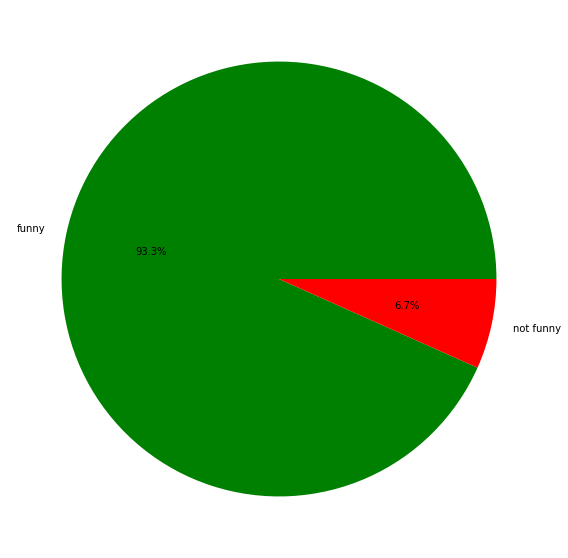

In [23]:
# print out as a pie chart how many jokes are funny or not
from matplotlib import pyplot as plt

# calculate number of posts with upvotes different grater than downvotes
funny = clean_df[clean_df['ups'] > clean_df['downs']]
not_funny = clean_df[clean_df['ups'] <= clean_df['downs']]
no_engagement = len(clean_df[(clean_df['ups'] == 0) & (clean_df['downs'] == 0)])


#calculate how many have only upvotes and zero downvotes
upvotes_count = downvotes_count = 0
for index in range(len(clean_df)):
    if clean_df['ups'][index] > 0:
        upvotes_count += 1
    elif clean_df['downs'][index] > 0:
        downvotes_count += 1

print("Number of jokes with upvotes different from zero: ", upvotes_count)
print("Number of jokes with downvotes different from zero: ", downvotes_count)
print("Number of jokes with no engagement: ", no_engagement)

# print average of the upvote ratio
print("Average upvote ratio: ", clean_df['upvote_ratio'].mean())


funny_percentage = len(funny) / len(clean_df) * 100
not_funny_percentage = len(not_funny) / len(clean_df) * 100

# set size of pie chart
plt.figure(figsize=(10,10))
plt.pie([funny_percentage, not_funny_percentage], labels=['funny', 'not funny'], autopct='%1.1f%%', colors=['green', 'red'])
plt.show()